In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
# import tf_keras as keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

# you may want to keep logging enabled when doing your own work
# disable Tensorflow warnings for this tutorial
import logging
tf.get_logger().setLevel(logging.ERROR) 
# disable Keras warnings for this tutorial
import warnings
warnings.simplefilter("ignore") 

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.0


In [2]:
project_path = '.'
RANDOM_STATE = 86
random.seed(RANDOM_STATE)
ORIGINAL_IMG_SIZE = (224, 224) # width, height
INPUT_IMG_SIZE = (224, 224) # width, height

IS_STABLE = 'binary'
STABLE_HEIGHT = 'stable_height'
TOTAL_HEIGHT = 'total_height'
CLASS_OFFSET = 1

# Prepare Data

In [3]:
def get_label_df(data_split):
	return pd.read_csv(f'COMP90086_2024_Project_{data_split}/{data_split}.csv')

In [4]:
def get_label(label_df, img_id, class_label = STABLE_HEIGHT):
	img_record = label_df.loc[label_df['id'] == img_id]
	if not img_record.empty:
		if class_label == IS_STABLE: 
			if 'instability_type' in img_record.columns:
				# CHANGED! stable: 1, unstable: 0
				return 1 if img_record['instability_type'].values[0] == 0 else 0
			else:
				print()
				print(img_id, img_record)
				raise KeyError(f"Required column instability_type is missing in the DataFrame.")
		elif class_label == STABLE_HEIGHT: 
			if STABLE_HEIGHT in img_record.columns:
				
				return int(img_record[STABLE_HEIGHT].values[0]) - 1
			else: 
				print()
				print(img_id, img_record)
				raise KeyError(f"Required columns '{STABLE_HEIGHT}' is missing in the DataFrame.")
		else: 
			if TOTAL_HEIGHT in img_record.columns:
				return int(img_record[TOTAL_HEIGHT].values[0]) - 2
			else: 
				print()
				print(img_id, img_record)
				raise KeyError("Required columns '{TOTAL_HEIGHT}' is missing in the DataFrame.")
	else:
		raise ValueError(f"Image ID {img_id} not found in the DataFrame.")

In [5]:
from keras.applications.inception_v3 import preprocess_input
import cv2

def centralize_object(image):
	# Convert to grayscale (assuming the object is in non-black pixels)
	gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
	
	# Find all non-black pixels (object area)
	non_zero_coords = cv2.findNonZero(gray)

	# Get the bounding box of the non-black pixels
	x, y, w, h = cv2.boundingRect(non_zero_coords)
	
	# Crop the object from the image
	cropped_obj = image[y:y+h, x:x+w]
	
	# Create a new black image of the same size
	centered_img = np.zeros_like(image)
	
	# Calculate the coordinates where the object should be placed to be centralized
	center_x = (ORIGINAL_IMG_SIZE[0] - w) // 2
	center_y = (ORIGINAL_IMG_SIZE[1] - h) // 2
	
	# Place the cropped object in the center of the new image
	centered_img[center_y:center_y+h, center_x:center_x+w] = cropped_obj
	
	return centered_img

def get_image(data_split, img_id, size, img_type = None): 
	img_folder = data_split if data_split != 'dev' else 'train'
	img_type = img_folder if img_type is None else img_type
	img_path = os.path.join(project_path, f'COMP90086_2024_Project_{img_folder}/{img_type}', f'{img_id}.jpg')
	img = image.load_img(img_path, target_size=size)
	img_np = image.img_to_array(img)
	img_array = centralize_object(img_np)
	img_array = np.expand_dims(img_np, axis=0)
	img_array = preprocess_input(img_array)
	
	return img, img_np, img_array

In [6]:
def get_object_by_color(img_np, color, non_gray_pixels_threshold, intensity, hue_range=21, debug=False):
	target_hue = None
	if color == 'red':
		target_hue = 0
	elif color == 'green':
		target_hue = 120
	elif color == 'blue':
		target_hue = 240
	elif color == 'yellow':
		target_hue = 60
	elif color == 'purple':
		target_hue = 300
	elif color == 'teal':
		target_hue = 180
	# print(color)
	
	lower_bound, upper_bound = target_hue - hue_range, target_hue + hue_range

	image_hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
	hue_channel = image_hsv[:, :, 0]

	mask = cv2.inRange(hue_channel, lower_bound, upper_bound)
	if color == 'red':
		lower_bound = 360 - hue_range
		upper_bound = hue_range
		mask1 = cv2.inRange(hue_channel, lower_bound, 360)
		mask2 = cv2.inRange(hue_channel, 0, upper_bound)
		mask = cv2.bitwise_or(mask1, mask2)
	
	masked_image = cv2.bitwise_and(img_np, img_np, mask=mask)
	
	masked_gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)
	non_gray_pixels = np.count_nonzero(masked_gray > intensity)
	if debug:
		print('Non gray pixels', color, non_gray_pixels)
	if non_gray_pixels > non_gray_pixels_threshold:
		if debug:
			plt.figure(figsize=(8, 8))
			plt.tight_layout()
			plt.subplot(1, 2, 1)
			plt.imshow(img_np.astype('uint8'))
			plt.title('Original')
			
			plt.subplot(1, 2, 2)
			plt.imshow(masked_image.astype('uint8'))
			plt.title(f'Masked {color}')
			
			plt.show()
		return masked_image
	return None

def get_lowest_object_position(masked_img_np, intensity, debug=False):
	gray = cv2.cvtColor(masked_img_np.astype('uint8'), cv2.COLOR_RGB2GRAY)
	
	_, thresh = cv2.threshold(gray, intensity, 255, cv2.THRESH_BINARY) # Intensity < 15: set to 0. o.w., set to 255
	contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	if not contours:
		return None
	largest_contour = max(contours, key=cv2.contourArea)
	x, y, w, h = cv2.boundingRect(largest_contour)
	if w < 10 or h < 10:
		if debug:
			print(f'Width or height of contour too small. w: {w}, h: {h}')
		return None
	return y+h
	
def get_all_objects(img_id, data_split, img_type, non_gray_pixels_threshold, intensity, hue_range=21, size=ORIGINAL_IMG_SIZE, debug=False):
	img_folder = data_split if data_split != 'dev' else 'train'
	img_type = img_folder if img_type is None else img_type
	img_path = os.path.join(project_path, f'COMP90086_2024_Project_{img_folder}/{img_type}', f'{img_id}.jpg')
	img = image.load_img(img_path, target_size=size)
	img_np = image.img_to_array(img)

	colors = ['red', 'green', 'blue', 'yellow', 'purple', 'teal']
	objects = []
	lowest_positions = []
	for color in colors:
		masked = get_object_by_color(img_np, color, non_gray_pixels_threshold, intensity, hue_range, debug)
		if masked is not None:
			max_y = get_lowest_object_position(masked, intensity, debug)
			if max_y is not None:
				objects.append(masked)
				lowest_positions.append(max_y)
				if debug:
					print('lowest pos', color, max_y)
	
	if not objects:
		return None, None
	
	# Lowest object first in the sorted array
	sorted_result = sorted(zip(lowest_positions, objects), key=lambda x: x[0], reverse=True)
	sorted_positions, sorted_objects = zip(*sorted_result)
	if debug:
		print(sorted_positions)

	return len(sorted_objects), sorted_objects

In [7]:
def stack_objects(sorted_objects, intensity=15, debug=False):
	base_np = sorted_objects[0]
	stacks = []
	for i, next_object in enumerate(sorted_objects[1:]):
		added_np = base_np.copy()
		gray_next_object = cv2.cvtColor(next_object, cv2.COLOR_RGB2GRAY)

		mask = gray_next_object > intensity
		added_np[mask] = next_object[mask]
		if debug:
			plt.imshow(added_np.astype('uint8'))
			plt.show()
		stacks.append((i+2, added_np))
		base_np = added_np
		
	return stacks

Non gray pixels red 909


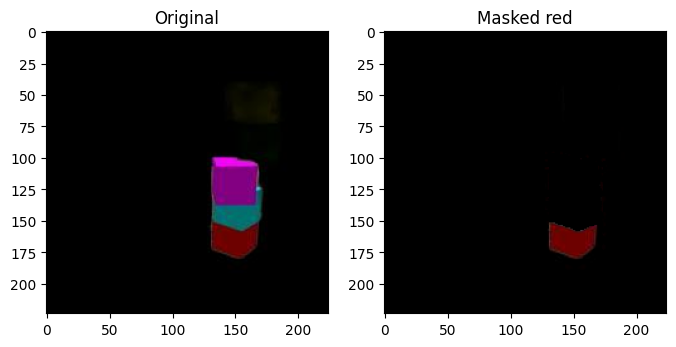

lowest pos red 182
Non gray pixels green 195


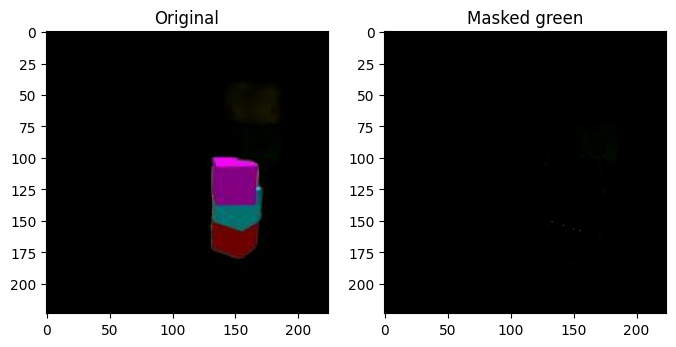

lowest pos green 103
Non gray pixels blue 62
Non gray pixels yellow 1362


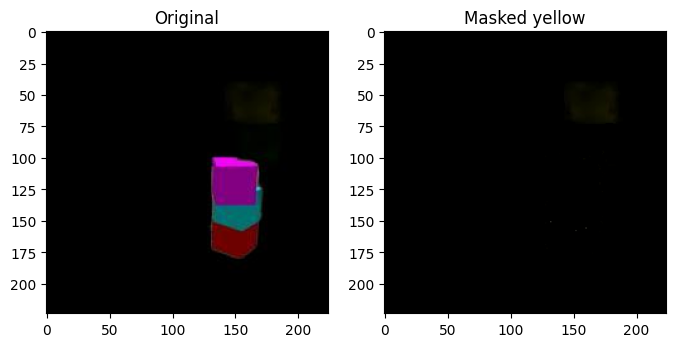

lowest pos yellow 74
Non gray pixels purple 1386


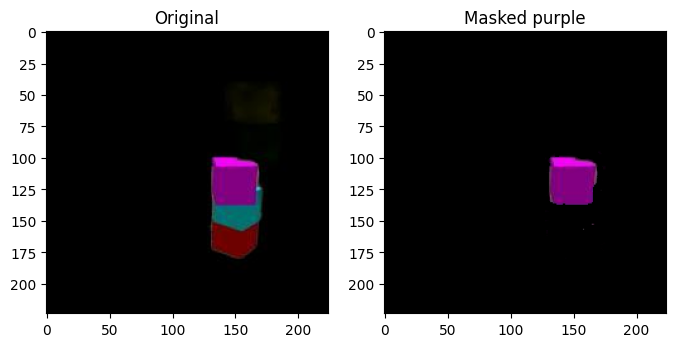

lowest pos purple 138
Non gray pixels teal 717


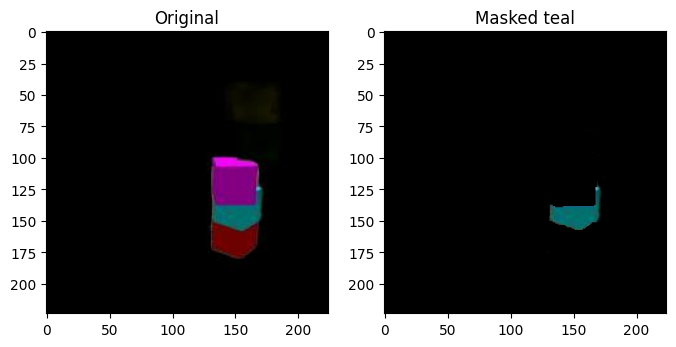

lowest pos teal 158
(182, 158, 138, 103, 74)


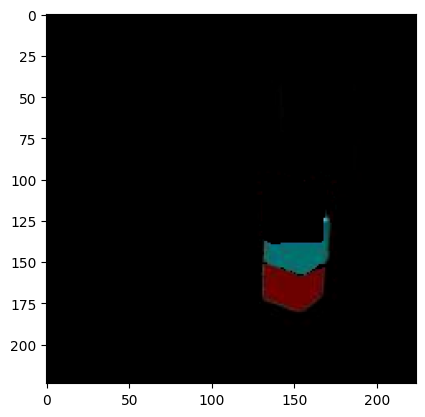

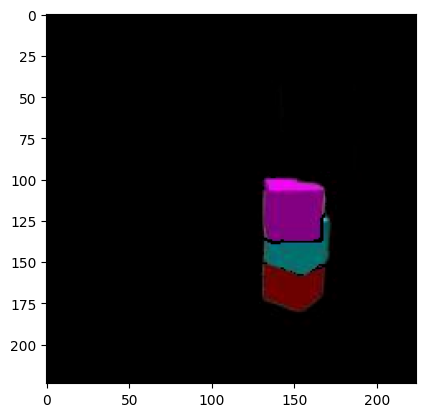

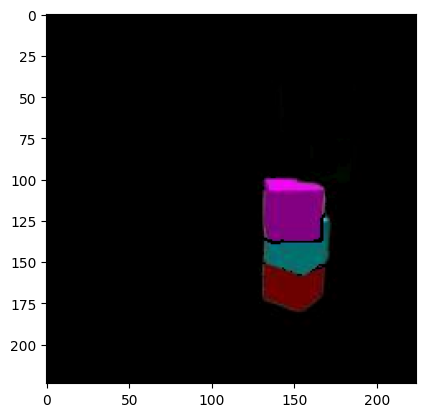

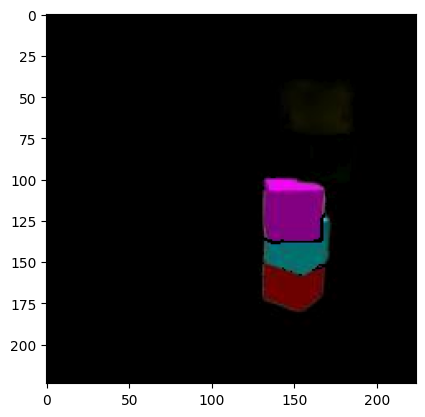

[(2,
  array([[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         ...,
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]], dt

In [8]:
n, objects = get_all_objects(177296, 'train', 'train_rm_background', 70, 4, debug=True)
stack_objects(objects, 4, debug=True)

In [ ]:
batch_size = 16
train_augmentations = []
original_img_type = 'train_rm_background'
class_label = IS_STABLE
img_size = INPUT_IMG_SIZE

# !!! Prepare_data function is in the Data Generator section below!!!
label_dfs_obj_seg_test, _, _, _, _, _, _, _, _ = prepare_data(original_img_type, batch_size, class_label, img_size, train_augmentations, oversample=False, online_augmentation=True, is_stratify=False)

Best total_height performance when hue_range=21, non_gray_pixels_threshold=70, intensity=4

In [58]:
def test_get_all_objects(hue_range, non_gray_pixels_threshold, intensity, debug=False):
	ids = label_dfs_obj_seg_test['train']['id'].values
	num_correct = 0
	for id in ids:
		n, objects = get_all_objects(id, 'train', 'train_rm_background', non_gray_pixels_threshold, intensity, hue_range=hue_range)
		if n is not None:
			total_height = get_label(label_dfs_obj_seg_test['train'], id, TOTAL_HEIGHT) + 2
			if n == total_height:
				num_correct += 1
			elif debug:
				print('error:', id, 'extracted height:', n, 'truth:', total_height)
	print('acc:', hue_range, non_gray_pixels_threshold, intensity, round(num_correct / len(ids), 4))			

In [57]:
for hue_range in range(21, 24):
	for t in range(40, 71, 10):
		for i in range(3, 7):
			test_get_all_objects(hue_range, t, i)		

acc: 21 40 3 0.8384
acc: 21 40 4 0.8379
acc: 21 40 5 0.8361
acc: 21 40 6 0.8366
acc: 21 50 3 0.84
acc: 21 50 4 0.841
acc: 21 50 5 0.8389
acc: 21 50 6 0.8397
acc: 21 60 3 0.8416
acc: 21 60 4 0.8423
acc: 21 60 5 0.8413
acc: 21 60 6 0.8407
acc: 21 70 3 0.8428
acc: 21 70 4 0.8439
acc: 21 70 5 0.8426
acc: 21 70 6 0.8424
acc: 22 40 3 0.8322
acc: 22 40 4 0.8311
acc: 22 40 5 0.8314
acc: 22 40 6 0.8314
acc: 22 50 3 0.8345
acc: 22 50 4 0.8356
acc: 22 50 5 0.8358
acc: 22 50 6 0.8356
acc: 22 60 3 0.8381
acc: 22 60 4 0.8385
acc: 22 60 5 0.8395
acc: 22 60 6 0.8384
acc: 22 70 3 0.8397
acc: 22 70 4 0.8413
acc: 22 70 5 0.841
acc: 22 70 6 0.84
acc: 23 40 3 0.8245
acc: 23 40 4 0.8224
acc: 23 40 5 0.8215
acc: 23 40 6 0.8231
acc: 23 50 3 0.8265
acc: 23 50 4 0.8286
acc: 23 50 5 0.8293
acc: 23 50 6 0.8307
acc: 23 60 3 0.8317
acc: 23 60 4 0.833
acc: 23 60 5 0.834
acc: 23 60 6 0.8359
acc: 23 70 3 0.834
acc: 23 70 4 0.8371
acc: 23 70 5 0.8385
acc: 23 70 6 0.8377


In [60]:
# Check error in best setting of get_all_objects
test_get_all_objects(21, 70, 4, debug=True)

error: 177296 extracted height: 5 truth: 6
error: 787525 extracted height: 5 truth: 6
error: 711300 extracted height: 5 truth: 6
error: 814059 extracted height: 3 truth: 6
error: 94247 extracted height: 5 truth: 4
error: 98878 extracted height: 5 truth: 6
error: 371160 extracted height: 5 truth: 6
error: 480134 extracted height: 6 truth: 5
error: 206335 extracted height: 4 truth: 5
error: 3178 extracted height: 5 truth: 4
error: 544013 extracted height: 3 truth: 6
error: 221236 extracted height: 5 truth: 6
error: 493282 extracted height: 5 truth: 6
error: 829405 extracted height: 4 truth: 5
error: 638723 extracted height: 6 truth: 5
error: 991993 extracted height: 4 truth: 5
error: 771936 extracted height: 6 truth: 4
error: 271732 extracted height: 5 truth: 6
error: 354339 extracted height: 5 truth: 6
error: 717371 extracted height: 3 truth: 6
error: 991584 extracted height: 5 truth: 4
error: 29551 extracted height: 4 truth: 5
error: 275643 extracted height: 4 truth: 5
error: 51665 ext

### Data Generator

In [13]:
import numpy as np
import pandas as pd
import keras.utils as image
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator

# Define online augmentations
datagen = ImageDataGenerator(
	rotation_range=10,       # Randomly rotate images
	zoom_range=0.2,          # Zoom in/out images
	# width_shift_range=0.1,
	# height_shift_range=0.1,
	# shear_range=0.2,
	horizontal_flip=True,    # Randomly flip images horizontally
	brightness_range=(0.7, 1.3),
	channel_shift_range=30.0,
	fill_mode='nearest'      # Fill empty pixels after transformations
)

# Define the generator function
def data_generator(data_split, all_samples, batch_size, shuffle=False, online_augmentation=False):
	num_samples = len(all_samples)

	while True:

		if shuffle:
			np.random.shuffle(all_samples)
		for offset in range(0, num_samples, batch_size):
			batch_paths = all_samples[offset:offset + batch_size]
			batch_images = []
			batch_labels = []

			for img_np, label in batch_paths:
				
				if online_augmentation: 
					img_np = datagen.random_transform(img_np)

				img_np = centralize_object(img_np)

				batch_images.append(img_np)
				batch_labels.append(label)

			# Convert lists to numpy arrays
			batch_images = preprocess_input(np.array(batch_images)) # Preprocess: scale betweel -1 and 1
			batch_images = np.array(batch_images)
			batch_labels = np.array(batch_labels)

			yield batch_images, batch_labels

def get_all_samples(label_df, data_split, original_img_type):
	img_ids = label_df['id'].values.copy() 
	# stable_samples = {
	# 	2: [],
	# 	3: [],
	# 	4: [],
	# 	5: [],
	# 	6: []
	# }
	# unstable_samples = {
	# 	2: [],
	# 	3: [],
	# 	4: [],
	# 	5: [],
	# 	6: []
	# }
	all_samples = []
	stable_num, unstable_num = 0, 0
	for img_id in img_ids:
		n, objects = get_all_objects(img_id, data_split, original_img_type, 70, 4)
		if objects is None:
			print('Could not find any objects:', img_id)
			continue
		stacked_objects = stack_objects(objects, 4)
		if not stacked_objects:
			continue
		
		stable_height = get_label(label_df, img_id, STABLE_HEIGHT) + 1
		stable_count = 0

		for height, stack_np in reversed(stacked_objects):
			if height <= stable_height:
				if stable_count > 1:
					continue
				stable_count += 1
				stable_num += 1
				# stable_samples[height].append(stack_np)
				all_samples.append((stack_np, 1))
				
			else:
				unstable_num += 1
				# unstable_samples[height].append(stack_np)
				all_samples.append((stack_np, 0))
				
	
	
	print('Stable:', stable_num, 'Unstable:', unstable_num)
	# Failed experiment: balance stable/unstable samples. Within each class, balance #samples of each extracted height
	# stable_heights_size = [len(stacks) for stacks in stable_samples.values()]
	# stable_heights_mean_size = int(np.mean(stable_heights_size))
	# print('Stable height mean size:', stable_heights_mean_size, 'Max size height:', np.argmax(stable_heights_size)+2, np.max(stable_heights_size), 'Min size height', np.argmin(stable_heights_size)+2, np.min(stable_heights_size))

	# unstable_heights_size = [len(stacks) for stacks in unstable_samples.values()]
	# unstable_heights_mean_size = int(np.mean(unstable_heights_size))
	# print('Unstable height mean size:', unstable_heights_mean_size, 'Max size height:', np.argmax(unstable_heights_size)+2, np.max(unstable_heights_size), 'Min size height', np.argmin(unstable_heights_size)+2, np.min(unstable_heights_size))
	
	# all_samples = []

	# for height, stacks in stable_samples.items():
	# 	all_samples += [(stack, 1) for stack in random.choices(stacks, k=stable_heights_mean_size)]
	
	# for height, stacks in unstable_samples.items():
	# 	all_samples += [(stack, 0) for stack in random.choices(stacks, k=unstable_heights_mean_size)]

	# labels = np.array(labels)
	# if data_split == 'train':
	# 	class_indices = {cls: np.where(labels == cls)[0] for cls in [0, 1]}

	# 	balanced_indices = np.append(np.random.choice(class_indices[1], unstable_num, replace=False), class_indices[0])
	# 	all_samples = all_samples[balanced_indices]
	# print(stable_num, unstable_num)
	return all_samples

# Prepare data for model training.
def prepare_data(original_img_type, batch_size, class_label, img_size=ORIGINAL_IMG_SIZE, train_augmentations = [], oversample = True, online_augmentation=True, is_stratify=True): 
	# Load the label CSVs
	label_dfs = {data_split: get_label_df(data_split) for data_split in ['train', 'test']}
	
	# Split train/dev
	stratify = label_dfs['train'][STABLE_HEIGHT]
	if not is_stratify:
		stratify = None
	train_df, dev_df = train_test_split(label_dfs['train'], test_size=0.2, random_state=RANDOM_STATE, stratify=stratify)

	label_dfs['train'] = train_df
	label_dfs['dev'] = dev_df

	print('Number of unique train samples:', label_dfs['train'].shape[0])
	print('Number of unique dev samples:', label_dfs['dev'].shape[0])

	activation = 'sigmoid' if class_label == IS_STABLE else 'softmax'
	loss = 'binary_crossentropy' if class_label == IS_STABLE else 'sparse_categorical_crossentropy'

	if class_label == IS_STABLE: 
		n_class = 1
		class_column = IS_STABLE
		label_dfs['train'][IS_STABLE] = 1
		label_dfs['train'].loc[label_dfs['train']['instability_type'] != 0, IS_STABLE] = 0
		label_dfs['dev'][IS_STABLE] = 1
		label_dfs['dev'].loc[label_dfs['dev']['instability_type'] != 0, IS_STABLE] = 0
		class_offset = 0
	else: 
		class_column = class_label
		class_labels = label_dfs['train'][class_column].unique()
		n_class = len(class_labels)
		if class_label == STABLE_HEIGHT:
			class_offset = 1
		else:
			class_offset = 2

	if oversample: 
		# oversampling
		X = label_dfs['train'].drop(columns=[STABLE_HEIGHT])
		y = label_dfs['train'][STABLE_HEIGHT]

		# Apply random oversampling
		ros = RandomOverSampler(random_state=RANDOM_STATE)
		X_resampled, y_resampled = ros.fit_resample(X, y)

		# Combine the resampled data
		label_dfs['train'] = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)
	
		print('Number of train samples after oversampling:', label_dfs['train'].shape[0])

	train_all_samples = get_all_samples(label_dfs['train'], 'train', original_img_type)
	dev_all_samples = get_all_samples(label_dfs['dev'], 'train', original_img_type)

	train_generator = data_generator('train', train_all_samples, batch_size, shuffle=True, online_augmentation=online_augmentation)
	validation_generator = data_generator('dev', dev_all_samples, batch_size) # validation doesn't use any augmentations
	
	return label_dfs, train_generator, validation_generator, activation, loss, n_class, class_offset, len(train_all_samples), dev_all_samples

def data_distribution(label_dfs, class_label): 
	num_train_sample, num_dev_sample = len(label_dfs['train']), len(label_dfs['dev'])
	print(f'training dataset has {num_train_sample} samples, dev dataset has {num_dev_sample} samples')
	class_counts = label_dfs['train'][class_label].value_counts()
	print(f'{class_label} train distribution: {class_counts/sum(class_counts)}')
	class_counts = label_dfs['dev'][class_label].value_counts()
	print(f'{class_label} dev distribution: {class_counts/sum(class_counts)}')


In [11]:
# current task
batch_size = 16
# train_augmentations = ['train_rm_background_flipped', 'train_rm_background_aspect_ratio', 'train_rm_background_color', 'train_rm_background_rotation']
train_augmentations = []
original_img_type = 'train_rm_background'
class_label = IS_STABLE
img_size = INPUT_IMG_SIZE

In [14]:
label_dfs, train_generator, validation_generator, activation, loss, n_class, class_offset, train_samples_num, dev_samples = prepare_data(original_img_type, batch_size, class_label, img_size, train_augmentations, online_augmentation=True, is_stratify=False)

steps_per_epoch_train = train_samples_num // batch_size
steps_per_epoch_dev = len(dev_samples) // batch_size

print()
print('loss:', loss)
print('activation:', activation)
print('Number of batches in training:', steps_per_epoch_train)
print('number of batches in dev:', steps_per_epoch_dev)

Number of unique train samples: 6144
Number of unique dev samples: 1536
Number of train samples after oversampling: 9432
Stable: 14079 Unstable: 11608
Stable: 1961 Unstable: 2516

loss: binary_crossentropy
activation: sigmoid
Number of batches in training: 1605
number of batches in dev: 279


In [13]:
for i, batch_data in enumerate(train_generator): 
	print(batch_data[0].shape)
	print(batch_data[1])
	break
label_dfs['train'].head(5)

(16, 224, 224, 3)
[0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1]


,id,shapeset,type,total_height,instability_type,cam_angle,binary,stable_height
0,177296,1,2,6,1,1,0,1
1,69840,1,1,3,1,2,0,1
2,672664,2,2,5,1,1,0,1
3,787525,2,2,6,2,1,0,5
4,848168,1,2,5,0,2,1,5


In [14]:
data_distribution(label_dfs, class_label)

training dataset has 9432 samples, dev dataset has 1536 samples
binary train distribution: binary
0    0.610793
1    0.389207
Name: count, dtype: float64
binary dev distribution: binary
0    0.753255
1    0.246745
Name: count, dtype: float64


# Evaluation

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
from tqdm import tqdm

def test_predict(model, label_dfs, data_split, img_type):
	'''Make prediction on a set of data'''
	pred_result = {'id': label_dfs[data_split]['id'].values, 'prediction':[]}

	for img_id in tqdm(label_dfs[data_split]['id']):
		n, sorted_objects = get_all_objects(img_id, data_split, img_type, 70, 4)
		stacked_objects = stack_objects(sorted_objects, 4)

		prediction = 1
		for height, stack_np in reversed(stacked_objects):
			stack_np = centralize_object(stack_np)
			img_array = np.expand_dims(stack_np, axis=0)
			pred = model.predict(preprocess_input(img_array), verbose=0)[0]
			if pred >= 0.5:
				prediction = height
				break

		pred_result['prediction'].append(prediction)
		
	pred_result = pd.DataFrame.from_dict(pred_result, orient='index').transpose()
	pred_result['id'] = pred_result['id'].astype(int)
	pred_result['prediction'] = pred_result['prediction'].astype(int)

	if STABLE_HEIGHT in label_dfs[data_split].columns:
		pred_result['label'] = label_dfs[data_split][STABLE_HEIGHT].values

		print(classification_report(pred_result['label'], pred_result['prediction'], digits=4))

	return pred_result

def conf_matrix(model, label_dfs, data_split, img_type): 
	'''Evaluate the model performance on a set of data'''
	pred_result = test_predict(model, label_dfs, data_split, img_type)
	
	conf_matrix = confusion_matrix(pred_result['label'], pred_result['prediction'])
	
	# normalize the confusion matrix by sum of each row (true label)
	conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)

	fig, ax = plt.subplots(1, 2, figsize=(12, 6))
	# Plot raw counts confusion matrix
	disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
	disp1.plot(ax=ax[0], values_format='d')
	ax[0].set_title('Confusion Matrix (Counts)')

	# Plot normalized confusion matrix
	disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized)
	disp2.plot(ax=ax[1], values_format=".2f")
	ax[1].set_title('Confusion Matrix (Normalized)')

	plt.tight_layout()
	plt.show()

	return pred_result

def conf_matrix_binary(model, samples):
	labels = []
	img_array = []
	for img_np, label in samples:
		img_np = centralize_object(img_np)
		img_array.append(img_np)
		labels.append(label)
	img_array = preprocess_input(np.array(img_array))
	preds = model.predict(img_array, verbose=0)
	preds_label = preds >= 0.5

	print(classification_report(labels, preds_label))
	conf_matrix = confusion_matrix(labels, preds_label)
	
	# normalize the confusion matrix by sum of each row (true label)
	conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)

	fig, ax = plt.subplots(1, 2, figsize=(12, 6))
	# Plot raw counts confusion matrix
	disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
	disp1.plot(ax=ax[0], values_format='d')
	ax[0].set_title('Confusion Matrix (Counts)')

	# Plot normalized confusion matrix
	disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized)
	disp2.plot(ax=ax[1], values_format=".2f")
	ax[1].set_title('Confusion Matrix (Normalized)')

	plt.tight_layout()
	plt.show()


In [16]:
def plot_history(history): 
	plot_acc(history)
	plot_loss(history)

def plot_acc(history): 
	plt.plot(history.history['accuracy'], label='Train')
	plt.plot(history.history['val_accuracy'], label='Validation')
	plt.ylabel('Accuracy')
	plt.xlabel('Epoch')
	plt.title('Training and validating accuracy')
	plt.grid(axis='y')
	plt.legend(loc='lower right')
	plt.show()

def plot_loss(history): 
	plt.plot(history.history['loss'], label='Train')
	plt.plot(history.history['val_loss'], label='Validation')
	plt.ylabel('Loss')
	plt.xlabel('Epoch')
	plt.title('Training and validating loss')
	plt.grid(axis='y')
	plt.legend(loc='lower right')
	plt.show()

In [17]:
def occlusion_test(model, img_np):
	stride = 30
	window_size = 30

	image_height, image_width = img_np.shape[:2]
	img_np = centralize_object(img_np)
	img_array = preprocess_input(np.expand_dims(img_np.copy(), axis=0))
	
	# Get the model's initial prediction
	original_score = model.predict(img_array, verbose=0)[0]
	# Initialize an empty heatmap to store the prediction drop
	heatmap = np.zeros((image_height, image_width))

	# Loop over the image with the occlusion window
	for y in range(0, image_height, stride):
		for x in range(0, image_width, stride):
			# Copy the image and occlude the windowed region
			occluded_image = img_np.copy()
			occluded_image[y:y+window_size, x:x+window_size, :] = 0.0
			occluded_image_array = preprocess_input(np.expand_dims(occluded_image.copy(), axis=0))
			
			# Predict using the occluded image
			occluded_prediction = model.predict(occluded_image_array, verbose=0)
			occluded_class_score = occluded_prediction[0]

			score_drop = original_score - occluded_class_score
			
			heatmap[y:y + window_size, x:x + window_size] = score_drop

	# Scale to a range -1 to 1
	heatmap /= heatmap.max()
	
	return heatmap

# Classification

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet50 import ResNet50

## ResNet

In [70]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', input_shape=[224, 224, 3], include_top=False)

# Add new custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D() (x)
# x = Dense(units = 1536, activation='relu') (x)
x = Dense(units = 256, activation='relu', kernel_regularizer=l2(0.01)) (x)
x = Dropout(rate = 0.3) (x)
predictions = Dense(n_class, activation=activation)(x) 

# Define the new model with the custom layers
resnet = Model(inputs=base_model.input, outputs=predictions)

# for layer in inception.layers:
#     layer.trainable = False
# for layer in inception.layers[-250:]:
#     layer.trainable = True

resnet.compile(optimizer=Adam(learning_rate=0.00001), loss=loss, metrics=['accuracy'])

print('Number of layers:', len(resnet.layers))
resnet.summary()

94765736/94765736 [==============================] - 9s 0us/step
Number of layers: 179
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
     

In [21]:
# Define the checkpoint callback
resnet_checkpoint = ModelCheckpoint(
	os.path.join(project_path, 'resnet_binary.keras'),   # Filepath to save the model
	monitor='val_accuracy',   # Monitor validation accuracy
	save_best_only=True,  # Only save the model if val_accuracy improves
	mode='max',  # Mode should be 'max' to save the model when val_accuracy increases
	verbose=1    # Print out info when saving
)

In [22]:
print(class_label)
label_dfs, train_generator, validation_generator, activation, loss, n_class, class_offset, num_train_samples, dev_samples = prepare_data(original_img_type, batch_size, class_label, img_size, train_augmentations, online_augmentation=True, is_stratify=False)

steps_per_epoch_train = num_train_samples // batch_size
steps_per_epoch_dev = len(dev_samples) // batch_size

print()
print('loss:', loss)
print('activation:', activation)
print('Number of batches in training:', steps_per_epoch_train)
print('number of batches in dev:', steps_per_epoch_dev)

# Train the model with the checkpoint callback
history = best_model.fit(
	train_generator,
	steps_per_epoch=steps_per_epoch_train, # number of batches per epoch in training
	validation_data=validation_generator,
	validation_steps=steps_per_epoch_dev, # number of batches per epoch in validation
	epochs=15,
	callbacks=[resnet_checkpoint]  
)


binary
Number of unique train samples: 6144
Number of unique dev samples: 1536
Number of train samples after oversampling: 9432
Stable: 14079 Unstable: 11608
Stable: 1961 Unstable: 2516

loss: binary_crossentropy
activation: sigmoid
Number of batches in training: 1605
number of batches in dev: 279
Epoch 1/15


2024-10-12 23:49:19.006835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1605/1605 [==============================] - ETA: 0s - loss: 0.9661 - accuracy: 0.8251

2024-10-13 00:04:30.399774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.70901, saving model to ./resnet_binary.keras
1605/1605 [==============================] - 959s 596ms/step - loss: 0.9661 - accuracy: 0.8251 - val_loss: 1.1412 - val_accuracy: 0.7090
Epoch 2/15
1605/1605 [==============================] - ETA: 0s - loss: 0.8322 - accuracy: 0.8362
Epoch 2: val_accuracy improved from 0.70901 to 0.72043, saving model to ./resnet_binary.keras
1605/1605 [==============================] - 988s 615ms/step - loss: 0.8322 - accuracy: 0.8362 - val_loss: 1.0110 - val_accuracy: 0.7204
Epoch 3/15
1605/1605 [==============================] - ETA: 0s - loss: 0.7196 - accuracy: 0.8515
Epoch 3: val_accuracy improved from 0.72043 to 0.73096, saving model to ./resnet_binary.keras
1605/1605 [==============================] - 1002s 624ms/step - loss: 0.7196 - accuracy: 0.8515 - val_loss: 0.9736 - val_accuracy: 0.7310
Epoch 4/15
1605/1605 [==============================] - ETA: 0s - loss: 0.6294 - accuracy: 0.8619
Epoch 4: val_a

## InceptionV3

In [17]:
# Load the InceptionV3 model without the top layers (fully connected layers), using ImageNet weights
inception_base_model = tf.keras.applications.InceptionV3(weights='imagenet', input_shape=[INPUT_IMG_SIZE[1], INPUT_IMG_SIZE[0], 3], include_top=False)

# Add new custom layers on top of the base model
x = inception_base_model.output
x = GlobalAveragePooling2D() (x)
# x = Dense(units = 1536, activation='relu') (x)
x = Dense(units = 256, activation='relu', kernel_regularizer=l2(0.01)) (x)
x = Dropout(rate = 0.3) (x)
predictions = Dense(n_class, activation=activation)(x) 

# Define the new model with the custom layers
inception = Model(inputs=inception_base_model.input, outputs=predictions)

# for layer in inception.layers:
#     layer.trainable = False
# for layer in inception.layers[-250:]:
#     layer.trainable = True

inception.compile(optimizer=Adam(learning_rate=0.00001), loss=loss, metrics=['accuracy'])

print('Number of layers:', len(inception.layers))
inception.summary()

Number of layers: 315
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                       

In [24]:
# Define the checkpoint callback
inception_checkpoint = ModelCheckpoint(
	os.path.join(project_path, 'inceptionv3_objSeg_newSegThres_binary-0.73.keras'),   # Filepath to save the model
	monitor='val_accuracy',   # Monitor validation accuracy
	save_best_only=True,  # Only save the model if val_accuracy improves
	mode='max',  # Mode should be 'max' to save the model when val_accuracy increases
	verbose=1    # Print out info when saving
)

In [19]:
print(class_label)
label_dfs, train_generator, validation_generator, activation, loss, n_class, class_offset, num_train_samples, dev_samples = prepare_data(original_img_type, batch_size, class_label, img_size, train_augmentations, online_augmentation=True, is_stratify=False)

steps_per_epoch_train = num_train_samples // batch_size
steps_per_epoch_dev = len(dev_samples) // batch_size

print()
print('loss:', loss)
print('activation:', activation)
print('Number of batches in training:', steps_per_epoch_train)
print('number of batches in dev:', steps_per_epoch_dev)

# Train the model with the checkpoint callback
history = inception.fit(
	train_generator,
	steps_per_epoch=steps_per_epoch_train, # number of batches per epoch in training
	validation_data=validation_generator,
	validation_steps=steps_per_epoch_dev, # number of batches per epoch in validation
	epochs=15,
	callbacks=[inception_checkpoint]  
)


binary
Number of unique train samples: 6144
Number of unique dev samples: 1536
Number of train samples after oversampling: 9432
Stable: 18670 Unstable: 11608
Stable height mean size: 3734 Max size height: 3 5031 Min size height 6 1209
Unstable height mean size: 2321 Max size height: 4 2957 Min size height 2 1553
Stable: 2423 Unstable: 2516
Stable height mean size: 484 Max size height: 2 956 Min size height 6 64
Unstable height mean size: 503 Max size height: 4 671 Min size height 6 319

loss: binary_crossentropy
activation: sigmoid
Number of batches in training: 1892
number of batches in dev: 308
Epoch 1/15


2024-10-05 14:43:17.714413: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 14:43:20.522415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1892/1892 [==============================] - ETA: 0s - loss: 4.3562 - accuracy: 0.6499

2024-10-05 14:55:30.630812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.60329, saving model to ./inceptionv3_objSeg_balHeight_binary.keras
1892/1892 [==============================] - 762s 400ms/step - loss: 4.3562 - accuracy: 0.6499 - val_loss: 3.6441 - val_accuracy: 0.6033
Epoch 2/15
1892/1892 [==============================] - ETA: 0s - loss: 2.9904 - accuracy: 0.7149
Epoch 2: val_accuracy improved from 0.60329 to 0.64184, saving model to ./inceptionv3_objSeg_balHeight_binary.keras
1892/1892 [==============================] - 759s 400ms/step - loss: 2.9904 - accuracy: 0.7149 - val_loss: 2.5944 - val_accuracy: 0.6418
Epoch 3/15
1892/1892 [==============================] - ETA: 0s - loss: 2.1340 - accuracy: 0.7512
Epoch 3: val_accuracy improved from 0.64184 to 0.66213, saving model to ./inceptionv3_objSeg_balHeight_binary.keras
1892/1892 [==============================] - 797s 421ms/step - loss: 2.1340 - accuracy: 0.7512 - val_loss: 1.9687 - val_accuracy: 0.6621
Epoch 4/15
1892/1892 [=========================

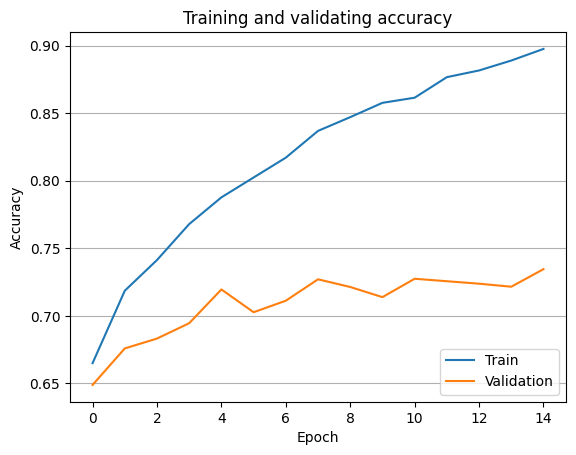

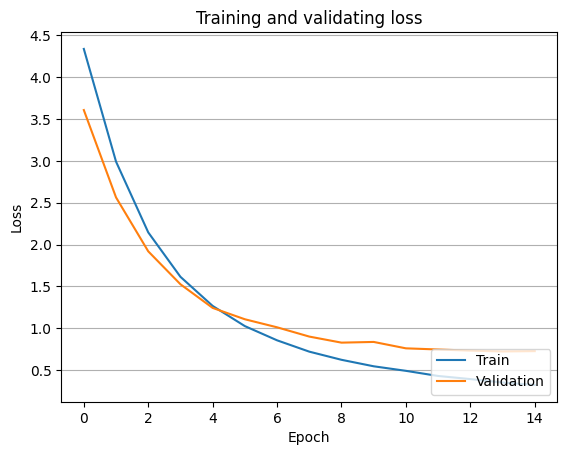

In [108]:
plot_history(history)

In [18]:
from keras.models import load_model
inception_best_model = load_model(os.path.join(project_path, 'inceptionv3_objSeg_newSegThres_binary-0.73_best.keras'))

inception_best_model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-10-13 16:53:52.991884: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-13 16:53:52.992047: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

  0%|          | 0/1536 [00:00<?, ?it/s]2024-10-13 16:54:10.624726: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-13 16:54:11.005933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
100%|██████████| 1536/1536 [02:43<00:00,  9.39it/s]


              precision    recall  f1-score   support

           1     0.5778    0.5546    0.5660       348
           2     0.5521    0.5729    0.5623       398
           3     0.4911    0.5272    0.5085       313
           4     0.4458    0.4534    0.4496       236
           5     0.4182    0.4132    0.4157       167
           6     0.5833    0.3784    0.4590        74

    accuracy                         0.5143      1536
   macro avg     0.5114    0.4833    0.4935      1536
weighted avg     0.5161    0.5143    0.5139      1536



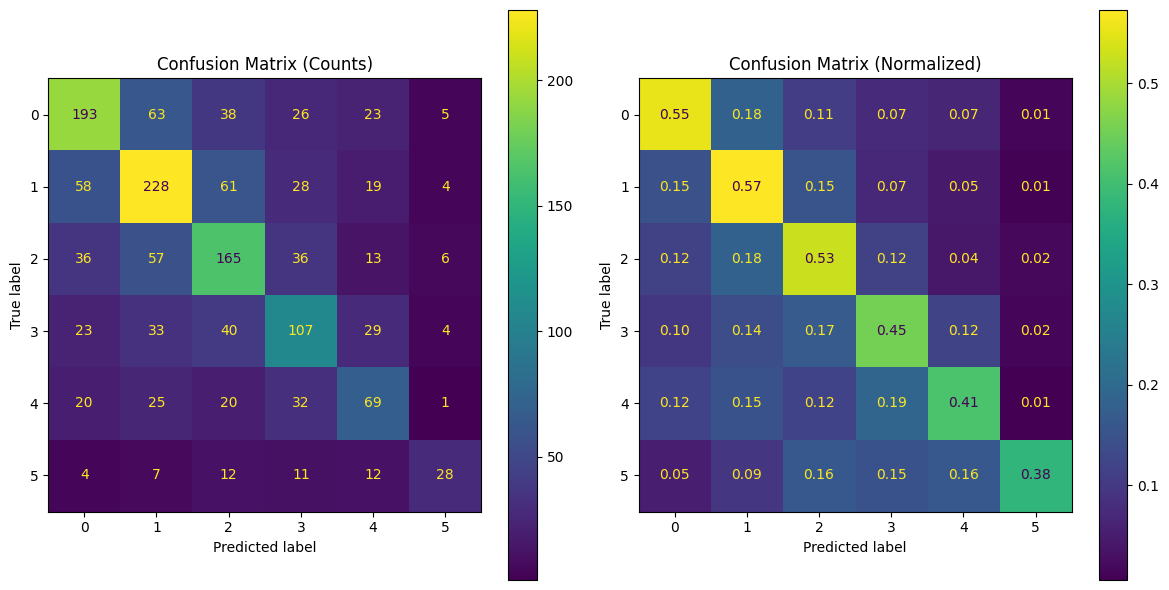

,id,prediction,label
0,369575,3,3
1,602724,2,2
2,269106,1,3
3,212749,1,3
4,324537,1,2
...,...,...,...
1531,863017,1,1
1532,992184,2,1
1533,6882,6,6
1534,757985,3,3


In [19]:
conf_matrix(inception_best_model, label_dfs, 'dev', 'train_rm_background')

## Best model

In [33]:
best_model = load_model(os.path.join(project_path, 'resnet_binary_best.keras'))

best_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

2024-10-13 10:01:37.164804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.77      0.76      0.76      2516
           1       0.70      0.71      0.70      1961

    accuracy                           0.74      4477
   macro avg       0.73      0.73      0.73      4477
weighted avg       0.74      0.74      0.74      4477



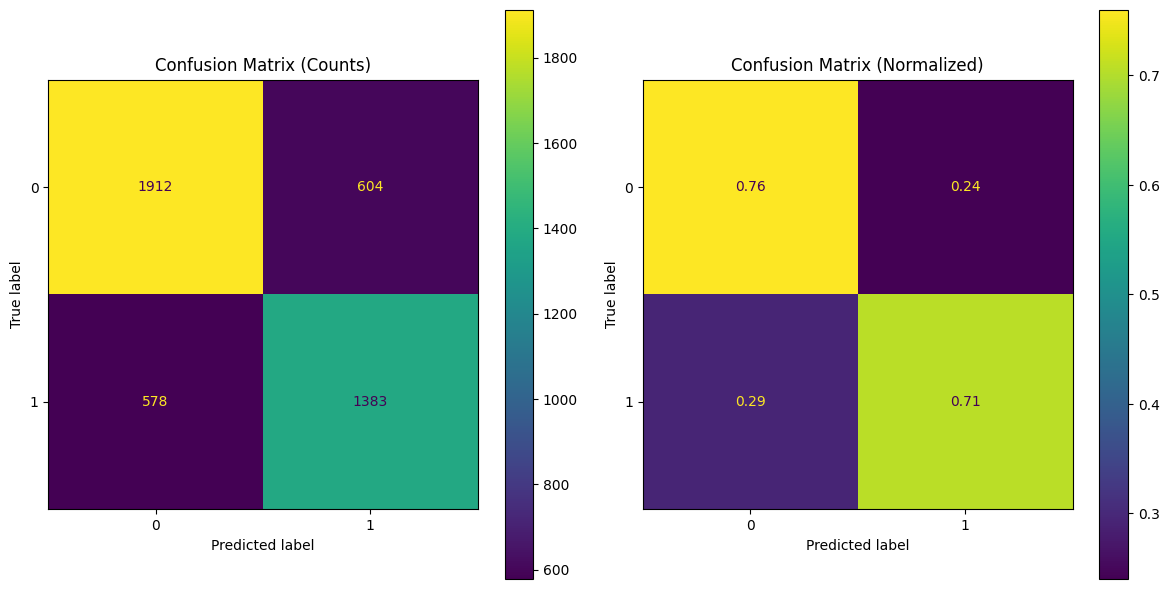

In [34]:
dev_result_ = conf_matrix_binary(best_model, dev_samples)

100%|██████████| 1536/1536 [02:33<00:00, 10.03it/s]


              precision    recall  f1-score   support

           1     0.6211    0.5086    0.5592       348
           2     0.5258    0.5879    0.5552       398
           3     0.4793    0.5559    0.5148       313
           4     0.4859    0.5127    0.4990       236
           5     0.4745    0.3892    0.4276       167
           6     0.4211    0.3243    0.3664        74

    accuracy                         0.5176      1536
   macro avg     0.5013    0.4798    0.4870      1536
weighted avg     0.5212    0.5176    0.5163      1536



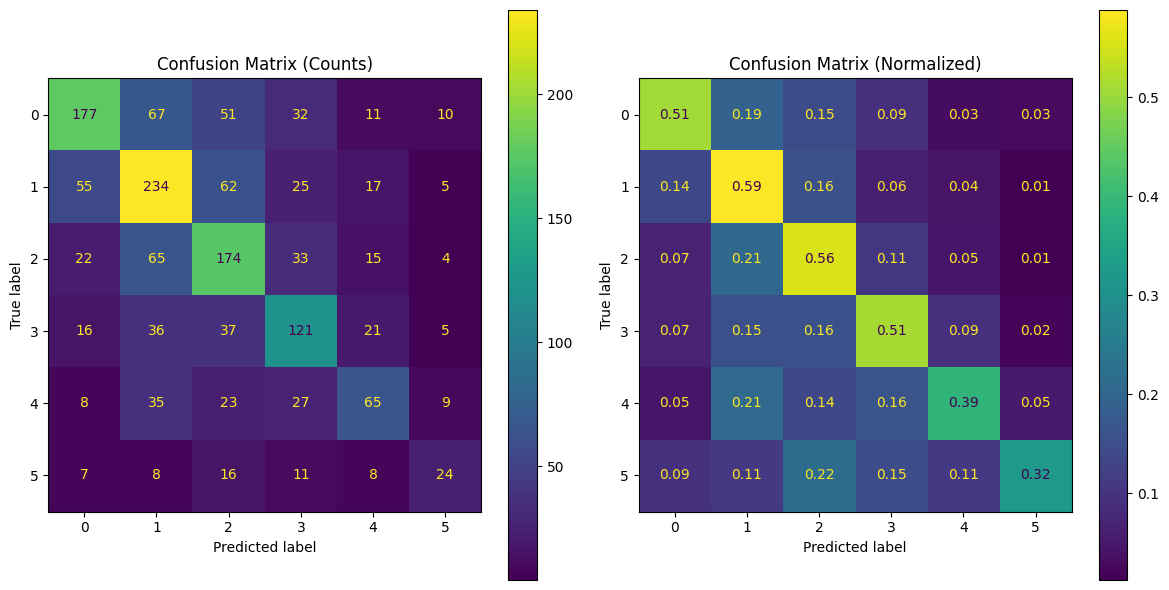

,id,prediction,label
0,369575,3,3
1,602724,2,2
2,269106,3,3
3,212749,2,3
4,324537,4,2
...,...,...,...
1531,863017,1,1
1532,992184,2,1
1533,6882,6,6
1534,757985,3,3


In [35]:
conf_matrix(best_model, label_dfs, 'dev', 'train_rm_background')

**Test set prediction**

In [26]:
pred_result = test_predict(best_model, label_dfs, 'test', 'test_rm_background')

100%|██████████| 1920/1920 [03:18<00:00,  9.65it/s]


In [27]:
test_df = pd.DataFrame.from_dict(pred_result)
test_df = test_df.rename({'prediction': 'stable_height'})
test_df.to_csv(os.path.join(project_path, 'COMP90086_2024_Project_test', 'prediction_resnet.csv'), index=False)

**Performance by the properties in metadata**

In [36]:
properties = [col for col in label_dfs['dev'].columns if col != 'id' and col != STABLE_HEIGHT and col != IS_STABLE]
for property in properties:
	print('=' * 20, property, '=' * 20)
	property_values = np.sort(label_dfs['dev'][property].unique())
	df_grouped = label_dfs['dev'].groupby(property)
	for property_value in property_values:
		print(f'{property} = {property_value}')
		df = df_grouped.get_group(property_value)
		test_predict(best_model, {'dev': df}, 'dev', img_type='train_rm_background')
	

==================== shapeset ====================
shapeset = 1


100%|██████████| 512/512 [00:55<00:00,  9.23it/s]


              precision    recall  f1-score   support

           1     0.5604    0.4359    0.4904       117
           2     0.4309    0.5865    0.4968       133
           3     0.4250    0.4513    0.4378       113
           4     0.4179    0.3733    0.3944        75
           5     0.4722    0.3208    0.3820        53
           6     0.3529    0.2857    0.3158        21

    accuracy                         0.4512       512
   macro avg     0.4432    0.4089    0.4195       512
weighted avg     0.4584    0.4512    0.4480       512

shapeset = 2


100%|██████████| 1024/1024 [01:37<00:00, 10.45it/s]


              precision    recall  f1-score   support

           1     0.6495    0.5455    0.5929       231
           2     0.5909    0.5887    0.5898       265
           3     0.5062    0.6150    0.5553       200
           4     0.5110    0.5776    0.5423       161
           5     0.4752    0.4211    0.4465       114
           6     0.4500    0.3396    0.3871        53

    accuracy                         0.5508      1024
   macro avg     0.5305    0.5146    0.5190      1024
weighted avg     0.5548    0.5508    0.5499      1024

==================== type ====================
type = 1


100%|██████████| 746/746 [01:11<00:00, 10.49it/s]


              precision    recall  f1-score   support

           1     0.7246    0.5682    0.6369       176
           2     0.6218    0.5911    0.6061       203
           3     0.5690    0.6828    0.6207       145
           4     0.5702    0.6330    0.6000       109
           5     0.5556    0.6164    0.5844        73
           6     0.4872    0.4750    0.4810        40

    accuracy                         0.6059       746
   macro avg     0.5881    0.5944    0.5882       746
weighted avg     0.6145    0.6059    0.6065       746

type = 2


100%|██████████| 790/790 [01:23<00:00,  9.47it/s]


              precision    recall  f1-score   support

           1     0.5238    0.4477    0.4828       172
           2     0.4524    0.5846    0.5101       195
           3     0.3968    0.4464    0.4202       168
           4     0.4062    0.4094    0.4078       127
           5     0.3571    0.2128    0.2667        94
           6     0.2778    0.1471    0.1923        34

    accuracy                         0.4342       790
   macro avg     0.4024    0.3747    0.3800       790
weighted avg     0.4299    0.4342    0.4259       790

==================== total_height ====================
total_height = 2


100%|██████████| 141/141 [00:06<00:00, 23.25it/s]


              precision    recall  f1-score   support

           1     0.7231    0.7015    0.7121        67
           2     0.7568    0.7568    0.7568        74
           3     0.0000    0.0000    0.0000         0

    accuracy                         0.7305       141
   macro avg     0.4933    0.4861    0.4896       141
weighted avg     0.7408    0.7305    0.7355       141

total_height = 3


100%|██████████| 227/227 [00:15<00:00, 15.08it/s]


              precision    recall  f1-score   support

           1     0.7021    0.4648    0.5593        71
           2     0.5795    0.6071    0.5930        84
           3     0.4944    0.6111    0.5466        72
           4     0.0000    0.0000    0.0000         0

    accuracy                         0.5639       227
   macro avg     0.4440    0.4208    0.4247       227
weighted avg     0.5909    0.5639    0.5678       227

total_height = 4


100%|██████████| 294/294 [00:26<00:00, 11.23it/s]


              precision    recall  f1-score   support

           1     0.6610    0.5735    0.6142        68
           2     0.4507    0.4444    0.4476        72
           3     0.4886    0.5658    0.5244        76
           4     0.4730    0.4487    0.4605        78
           5     0.0000    0.0000    0.0000         0

    accuracy                         0.5068       294
   macro avg     0.4147    0.4065    0.4093       294
weighted avg     0.5151    0.5068    0.5094       294

total_height = 5


100%|██████████| 384/384 [00:43<00:00,  8.84it/s]


              precision    recall  f1-score   support

           1     0.4815    0.4194    0.4483        62
           2     0.4271    0.5062    0.4633        81
           3     0.5158    0.5833    0.5475        84
           4     0.5584    0.5658    0.5621        76
           5     0.5000    0.3827    0.4336        81

    accuracy                         0.4948       384
   macro avg     0.4966    0.4915    0.4909       384
weighted avg     0.4966    0.4948    0.4926       384

total_height = 6


100%|██████████| 490/490 [01:04<00:00,  7.59it/s]


              precision    recall  f1-score   support

           1     0.5333    0.4000    0.4571        80
           2     0.4655    0.6207    0.5320        87
           3     0.4270    0.4691    0.4471        81
           4     0.4526    0.5244    0.4859        82
           5     0.4658    0.3953    0.4277        86
           6     0.4211    0.3243    0.3664        74

    accuracy                         0.4592       490
   macro avg     0.4609    0.4556    0.4527       490
weighted avg     0.4614    0.4592    0.4547       490

==================== instability_type ====================
instability_type = 0


100%|██████████| 379/379 [00:28<00:00, 13.13it/s]


              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         0
           2     0.4746    0.7568    0.5833        74
           3     0.4835    0.6111    0.5399        72
           4     0.5645    0.4487    0.5000        78
           5     0.7750    0.3827    0.5124        81
           6     1.0000    0.3243    0.4898        74

    accuracy                         0.5013       379
   macro avg     0.5496    0.4206    0.4376       379
weighted avg     0.6616    0.5013    0.5245       379

instability_type = 1


100%|██████████| 790/790 [01:24<00:00,  9.31it/s]


              precision    recall  f1-score   support

           1     0.6071    0.3414    0.4370       249
           2     0.3982    0.4265    0.4119       211
           3     0.3459    0.3879    0.3657       165
           4     0.3281    0.4000    0.3605       105
           5     0.2500    0.3333    0.2857        60
           6     0.0000    0.0000    0.0000         0

    accuracy                         0.3810       790
   macro avg     0.3216    0.3149    0.3101       790
weighted avg     0.4326    0.3810    0.3938       790

instability_type = 2


100%|██████████| 367/367 [00:42<00:00,  8.66it/s]


              precision    recall  f1-score   support

           1     0.9109    0.9293    0.9200        99
           2     0.8713    0.7788    0.8224       113
           3     0.7586    0.8684    0.8098        76
           4     0.7458    0.8302    0.7857        53
           5     0.8235    0.5385    0.6512        26
           6     0.0000    0.0000    0.0000         0

    accuracy                         0.8283       367
   macro avg     0.6850    0.6575    0.6649       367
weighted avg     0.8371    0.8283    0.8287       367

==================== cam_angle ====================
cam_angle = 1


100%|██████████| 1146/1146 [01:57<00:00,  9.79it/s]


              precision    recall  f1-score   support

           1     0.6748    0.5305    0.5940       262
           2     0.5606    0.6208    0.5892       298
           3     0.4965    0.5983    0.5426       234
           4     0.5275    0.5424    0.5348       177
           5     0.4200    0.3471    0.3801       121
           6     0.4130    0.3519    0.3800        54

    accuracy                         0.5419      1146
   macro avg     0.5154    0.4985    0.5035      1146
weighted avg     0.5467    0.5419    0.5405      1146

cam_angle = 2


100%|██████████| 390/390 [00:37<00:00, 10.35it/s]

              precision    recall  f1-score   support

           1     0.4810    0.4419    0.4606        86
           2     0.4261    0.4900    0.4558       100
           3     0.4198    0.4304    0.4250        79
           4     0.3731    0.4237    0.3968        59
           5     0.6216    0.5000    0.5542        46
           6     0.4545    0.2500    0.3226        20

    accuracy                         0.4462       390
   macro avg     0.4627    0.4227    0.4358       390
weighted avg     0.4534    0.4462    0.4465       390



**Occlusion test**

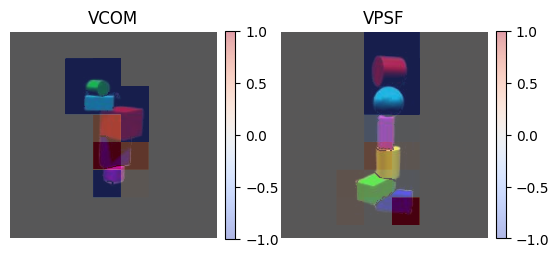

In [76]:
img_indexes = [540, 43]
instabilities = ['VCOM', 'VPSF']

fig, axes = plt.subplots(1, 2)
for i, img_index in enumerate(img_indexes):
    img_np, label = dev_samples[img_index]
    img_np = centralize_object(img_np)
    axes[i].imshow(img_np.astype('uint8'))
    heatmap = occlusion_test(best_model, img_np)
    im = axes[i].imshow(heatmap, cmap='coolwarm', alpha=0.4, vmin=-1, vmax=1)
    axes[i].set_axis_off()
    axes[i].set_title(instabilities[i])
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axes[i])
plt.show()

**Visualisation of feature maps**

In [77]:
from keras.models import Model

# Extracts the ouput of the top 1 layer (excluding the input layer)
layer_outputs = [layer.output for layer in best_model.layers[1:301]]  

activation_model = Model(inputs=best_model.input, outputs=layer_outputs)

img_np, label = dev_samples[300]
img_np = centralize_object(img_np)
img_array = preprocess_input(np.expand_dims(img_np.copy(), axis=0))

activations = activation_model.predict(img_array)

print('Number of outputs:', len(activations))
print('Dim of each output:', activations[0].shape)

layer_names = [layer.name for layer in best_model.layers[1:301]]

2024-10-13 15:23:58.600685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
Number of outputs: 178
Dim of each output: (1, 230, 230, 3)


In [78]:
selected_activations = []
selected_layer_names = []
for selected_index in [0, 19]: # first and the 20th layer
    selected_activations.append(activations[selected_index])
    selected_layer_names.append(layer_names[selected_index])

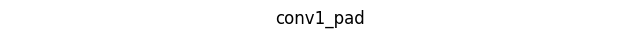

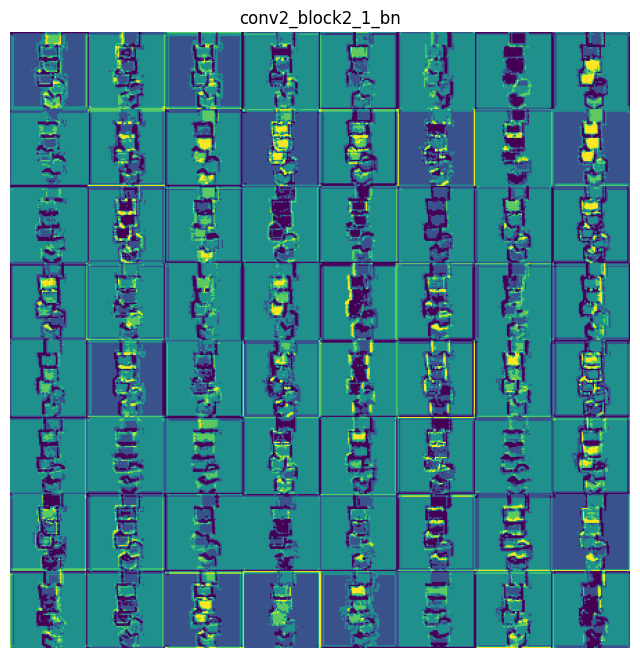

In [79]:
img_per_row = 8    

# Displays the activations
for layer_name, layer_activation in zip(selected_layer_names, selected_activations):
    # Number of channels in the layer
    n_channel = layer_activation.shape[-1]
    # The feature map with shape (1, size, size, n_channel).
    size = layer_activation.shape[1]
    # Tiles the activation channels in this matrix
    n_col = n_channel // img_per_row
    display_grid = np.zeros((size * n_col, img_per_row * size))
    # Tiles each filter into a big horizontal grid
    for col in range(n_col):
        for row in range(img_per_row):
            channel_image = layer_activation[0,:, :,col * img_per_row + row]
            # Post-processes the feature to make it visually palatable
            channel_image = (channel_image-channel_image.mean())//channel_image.std()  
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8') # limit the values in channel_image, resulting in a range of [0, 255]
            # Displays the grid
            display_grid[col * size : (col + 1) * size,
            row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0])) # display_grid is of shape of size * img_per_row
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')